In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Lecture 3: Regularisation

We will now re-run the simple MLP exercise from lecture 1 but this time with regularisation. Let's import all the functions we need and reload the data (**don't forget to mount the drive and add the path to the dataframe relative to your own drive**)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split

# STUDENTS CODE HERE - UPDATE THE PATH TO CORRESPOND TO WHERE YOU HAVE UPLOADED prem_vs_termwrois.pkl TO YOUR DRIVE #
file_path='/content/drive/My Drive/Colab Notebooks/AdvancedML/2021/01_fundamentals/prem_vs_termwrois.pkl'
# Read the data
df = pd.read_pickle(file_path)
data = df.values[:,:-2]
y = df.values[:,-1]

# create a test and train split
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.1, random_state=42)

# Create feature matrix
X_train = X_train.T
X_test=X_test.T
bias_row=np.ones((1,X_train.shape[1]))
print(X_train.shape,X_test.shape)

print(bias_row.shape)
X_train = np.concatenate((np.ones((1,X_train.shape[1])),X_train))
X_test = np.concatenate((np.ones((1,X_test.shape[1])),X_test))



# set variables for numbers of feature and examples to improve readabiity of code
n_features=X_train.shape[0]-1
n_examples=X_train.shape[1]

print('Dimension of X is ', X_train.shape,data.shape)
print('Dimension of y is ', y.shape)

print('Number of features', n_features)
print('Number of examples', n_examples)

(300, 90) (300, 11)
(1, 90)
Dimension of X is  (301, 90) (101, 300)
Dimension of y is  (101,)
Number of features 300
Number of examples 90


## The multi-layer perceptron (MLP)

Our MLP for binary classification contains a single hidden layer (with five units and ReLu activation) and a sigmoid classification output layer, such that:

$$ \hat{y} = f_2 \left( \mathbf{W_2} f_1 \left(\mathbf{W_1}\mathbf{X}\right) \right) $$

with:

$$ \text{Relu}(x) = \text{max}(0,x)$$

<figure align="center">
<img src="https://drive.google.com/uc?id=1I-1ALBHTlOzmVNSIBiruW3vhS51kejtf" alt="Drawing" width="500px;"/>
</figure>


This is implemented with forward pass:

$$
\mathbf{Z}_1 = \mathbf{W}_1 \mathbf{X} \\
\mathbf{F}_1 = \text{max}(0,\mathbf{Z_1}) \\
\mathbf{Z}_2 = \mathbf{W}_2 \mathbf{F}_1 \\
\mathbf{F}_2 = \dfrac{1}{1+e^{- \mathbf{Z_2}}} \\
\mathbf{L}  =  - \mathbf{Y} \ln(\mathbf{F_2}) - (1-\mathbf{Y}) \ln(1-\mathbf{F_2})
$$

And backwards pass:

$$\frac{\delta L}{\delta \mathbf{F}_2}=\frac{\mathbf{F}_2-\mathbf{Y}}{\mathbf{F}_2(1-\mathbf{F}_2)} \\
\frac{\delta  \mathbf{F}_2}{\delta  \mathbf{Z}_2}=\mathbf{F}_2(1-\mathbf{F}_2) \\
\frac{\delta  \mathbf{Z}_2}{\delta  \mathbf{W}_2}=\mathbf{F_1} \\
\frac{\delta  \mathbf{Z}_2}{\delta  \mathbf{F}_1}=\mathbf{W_2^T}\\
\frac{\delta  \mathbf{F}_1}{\delta  \mathbf{Z}_1}=1(\mathbf{Z}_1 >0)\\
\frac{\delta  \mathbf{Z}_1}{\delta  \mathbf{W}_1}=\mathbf{X}\\ $$

Let us redefine the functions from notebook 01-fundamentals.ipynb and re-run the training.

In [5]:
def f(z):
    return 1 / (1+ np.exp(-z))

def relu(x):
    # Answer
    return x * (x>=0)

def loss(y, y_pred):
    epsilon = 1e-5
    # note the negative sign so that the loss decreases as our predictions get better
    # we must add a small penaty term to prevent calculation of log(0)
    L = - y * np.log(y_pred+epsilon) - (1-y) * np.log(1-y_pred+epsilon) 
    J = np.mean(L)
    return J

def accuracy(y, y_pred, threshold = 0.5):
    y_pred_thresholded = y_pred > threshold
    correct_predictions = np.sum(y==y_pred_thresholded)  
    total_predictions = np.shape(y)
    accuracy = 100 * correct_predictions / total_predictions
    return accuracy

[94.44444444]


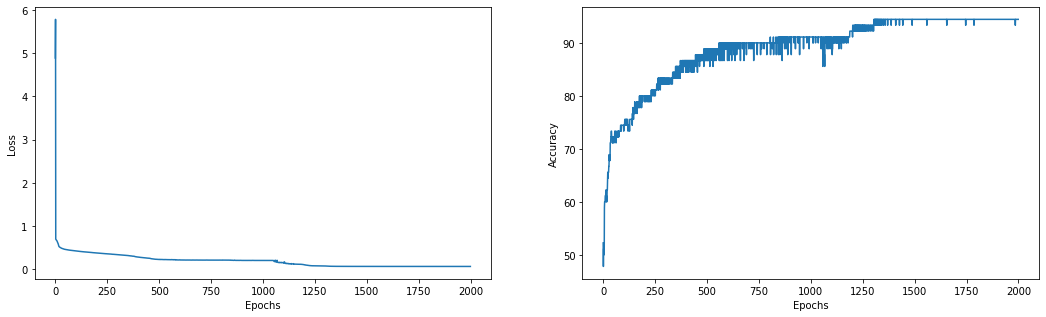

In [8]:
epsilon = 1e-5

# normalise X
X_norm = np.ones_like(X_train)
X_norm[1:] = (X_train[1:] -X_train[1:].min(axis=1,keepdims=True) )/ (X_train[1:].max(axis=1,keepdims=True)-X_train[1:].min(axis=1,keepdims=True)+epsilon)

# initialise w1, w2
W1 = np.random.randn(5,X_train.shape[0])
W2 = np.random.randn(1,5)

# we'll store the loss and accuracy in these lists during training
loss_record_mlp = []
accuracy_record_mlp = []

num_iterations = 2000
learning_rate = 1e-2


for i in range(num_iterations):
    # forward pass - get predictions
    
    #### STUDENT CODE HERE####
    # please keep the output names of each stage so they work later with backprop
    Z1 = np.matmul(W1,X_norm)
    F1 = relu(Z1)
    Z2 = np.matmul(W2,F1)
    F2 = f(Z2) # recall f is the sigmoid function
    l = loss(y_train,F2) 

    # store the loss/ accuracy at this iteration
    loss_record_mlp.append(l)
    accuracy_record_mlp.append(accuracy(y_train,F2))

    
    #backwards pass to get gradients
    dL_dW2=np.matmul(F2-y_train,F1.T) 
    dL_df1=np.matmul((F2-y_train).T,W2)  
    df1_dZ1  = 1.0 *(Z1> 0)
    
    dL_dZ1=np.multiply(dL_df1.T,df1_dZ1)
    dL_dW1 = np.matmul(dL_dZ1,X_norm.T)
    dJ_dW2=(1/W2.shape[0])*dL_dW2 
    dJ_dW1=(1/W1.shape[0])*dL_dW1 

    # update the weights
    W2 = W2 - learning_rate * dJ_dW2    
    W1 = W1 - learning_rate * dJ_dW1
    
# plot loss and accuracy    
fig, ax = plt.subplots(1,2, figsize = (18,5))
ax[0].plot(loss_record_mlp)
ax[1].plot(accuracy_record_mlp)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy');

print(accuracy(y_train,F2))

Testing on left out data

In [9]:
# norm X
X_test_norm= np.ones_like(X_test)
X_test_norm[1:] = (X_test[1:] -X_test[1:].mean(axis=1,keepdims=True)) / (X_test[1:].max(axis=1,keepdims=True) - X_test[1:].min(axis=1,keepdims=True) +epsilon)

Z1_test = np.matmul(W1,X_test_norm)
F1_test = relu(Z1_test)
Z2_test = np.matmul(W2,F1_test)
F2_test = f(Z2_test) 
l = loss(y_test,F2_test) 

print(l,accuracy(y_test,F2_test))

0.673522377345591 [90.90909091]


## Adding Regularisation

One problem with neural networks is that they can involve the training of very high numbers of parameters (defined by the total number of elements in all our weights matrices). The more parameters we can chose from the greater the chance of overfitting 


<figure align="center">
<img src="https://drive.google.com/uc?id=1ZKuwPsBML5vU41hQI0jM8YGwWFwdOP6v" alt="Drawing" width="800px;"/>
</figure>

There are several ways of controlling the capacity of Neural Networks to prevent overfitting. These include

1. L1 and L2 regularisation – penalise the network through addition of a penalty term i.e. 

$$ J =\frac{1}{n} (\sum_i L_i + \lambda <\textrm{penalty term}>)$$

2. Dropout - during training keep only a subset of neurons active (with probability 𝑝); set to zero otherwise.

Dropout will be considered in more detail in lecture 4. Here, we will consider the inclusion of a penalty term. Of these L2 is the most common.  This requires a penalty of $\lambda/2 ‖\mathbf{W}‖^2$ (where the 1/2  term is used to make gradient $\lambda ‖\mathbf{W}‖ $ rather than $2 \lambda ‖\mathbf{W}‖ $). L2 regularisation encourages the network to learn diffuse weights (small weights spread across all units). On the other hand, L1 has a penalty $\lambda ‖\mathbf{W}‖ $ and this encourages the learning of sparse weights, where many individual weights are set to zero.

**Task** lets try adding L2 regularisation to our MLP network. First write a new loss function which estimates a L2 regularised loss

In [10]:
def regularised_loss(y, y_pred, W1,W2, lambda_term,epsilon):
    '''
        Estimate loss with L2 regularisation
        
    input:
        y: True label
        y_pred: estimate label
        W1: weights matrix for hidden layer
        W2: weights matrix for output layer
        lambda_term: equals weighting for penalty term
        epsilon: small term to prevent log(0)
    returns:
        J: L2 regularised cross entropy loss
        
    '''
    # STUDENTS IMPLEMENT REGULARISATION TERM
    reg=0.5*lambda_term*np.sum(W1*W1) + 0.5*lambda_term*np.sum(W2*W2)
    L = - y * np.log(y_pred+epsilon) - (1-y) * np.log(1-y_pred+epsilon)
    J = np.mean(L) + reg
    return J

Now making a copy of the code from above but changing the call to the loss function 

**Task** update the gradients:

[88.88888889]


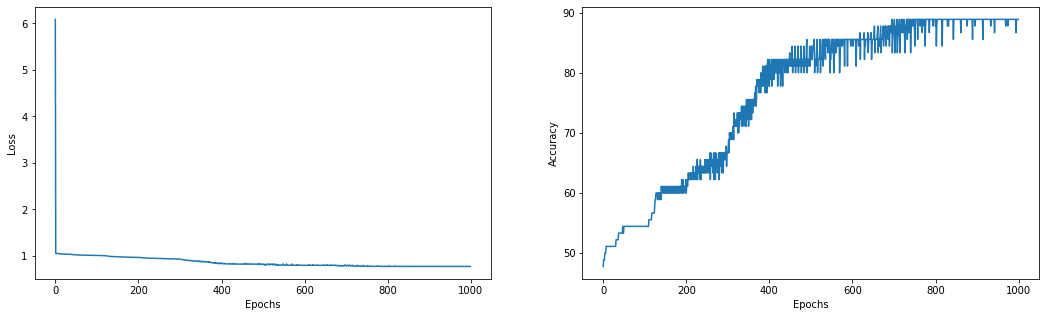

In [14]:
epsilon = 1e-5

# define lambda - penalty term weighting 
#(can't use variable name lambda as it is a python operation)
lambda_term=5e-4 

# initialise w1, w2
W1 = np.random.randn(5,X_train.shape[0])
W2 = np.random.randn(1,5)

# we'll store the loss and accuracy in these lists during training
loss_record_mlp = []
accuracy_record_mlp = []

num_iterations = 1000
learning_rate = 1e-2


for i in range(num_iterations):
    # forward pass - get predictions
    
    Z1 = np.matmul(W1,X_norm)
    F1 = relu(Z1)
    Z2 = np.matmul(W2,F1)
    F2 = f(Z2) # recall f is the sigmoid function
    
    l = regularised_loss(y_train,F2,W1,W2,lambda_term,epsilon)

    # store the loss/ accuracy at this iteration
    loss_record_mlp.append(l)
    accuracy_record_mlp.append(accuracy(y_train,F2))

    #backwards pass to get gradients
    dL_dW2=np.matmul(F2-y_train,F1.T) 
    dL_df1=np.matmul((F2-y_train).T,W2)  
    df1_dZ1  = 1.0 *(Z1> 0)
    
    dL_dZ1=np.multiply(dL_df1.T,df1_dZ1)
    dL_dW1 = np.matmul(dL_dZ1,X_norm.T)
    dJ_dW2=(1/W2.shape[0])*dL_dW2 
    dJ_dW1=(1/W1.shape[0])*dL_dW1 
    
    #update the loss to add the gradient of the penalty term
    dJ_dW2+=lambda_term*W2
    dJ_dW1+=lambda_term*W1

    # update the weights
    W2 = W2 - learning_rate * dJ_dW2    
    W1 = W1 - learning_rate * dJ_dW1
    
# plot loss and accuracy    
fig, ax = plt.subplots(1,2, figsize = (18,5))
ax[0].plot(loss_record_mlp)
ax[1].plot(accuracy_record_mlp)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy');

print(accuracy(y_train,F2))

Testing ...

In [15]:

Z1_test = np.matmul(W1,X_test_norm)
F1_test = relu(Z1_test)
Z2_test = np.matmul(W2,F1_test)
F2_test = f(Z2_test) 
l = loss(y_test,F2_test) 

print(l,accuracy(y_test,F2_test))

5.135384664586088 [45.45454545]
